<font face="vazir" size=5><div dir=rtl>
نصب و راه‌اندازی کتاب‌خانه‌ها

In [1]:
import sklearn
import pandas as pd
import io
import os
import copy
import pdb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(color_codes=True)

from google.colab import drive
from tqdm.notebook import trange, tqdm
from IPython.display import clear_output

from sklearn.metrics import f1_score

from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import initializers
from keras.regularizers import l2,l1,l1_l2
from keras import callbacks

In [2]:
# Diable warnings about max_itr not reached etc.!
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

<font face="vazir" size=5><div dir=rtl>
آماده‌سازی دیتاست
<font face="vazir" size=4><div dir=rtl>
دیتاست ما حاوی ۱۰ کلاس مرتبط با فشن و ۶۰۰۰۰ عکس ۲۸*۲۸ است. 
همچنین دیتاست تست به همین شکل و حاوی ۱۰۰۰۰ عکس است.

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

clear_output()
print("Done!")

Done!


In [4]:
print("X Train Shape: ", X_train.shape)
print("X Test Shape: ", X_test.shape)

X Train Shape:  (60000, 28, 28)
X Test Shape:  (10000, 28, 28)


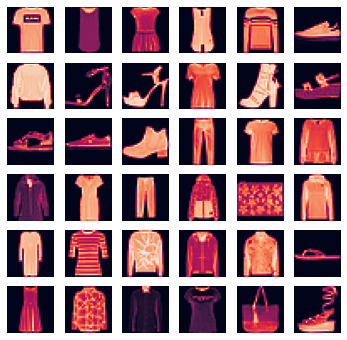

In [5]:
fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(6,6))
itr = 0
for i in range(0,6):
  for j in range(0,6):
    itr += 1
    
    # convert to unsigned integers
    image = X_train[itr,:,:]
 
    # plot image
    ax[i,j].imshow(image)
    ax[i,j].axis('off')

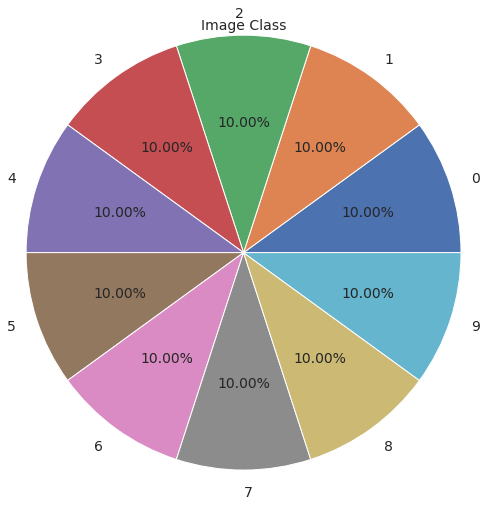

In [6]:
y_df = pd.DataFrame(y_train)
selected_labels = range(0,10)
y_df.value_counts().plot(
    kind = 'pie',figsize=(16,8),autopct='%1.2f%%',ylabel='',radius=1.25,labels=selected_labels,fontsize=14)

# Now let's setup the labels, titles and format y axis as percentages
plt.title("Image Class",fontsize=14)
#plt.legend(selected_labels,loc='lower right',fontsize=14)
plt.show()

In [7]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],X_train.shape[2], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

In [8]:
X_train = X_train/255.
X_test = X_test/255.

In [9]:
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer
enc = LabelBinarizer()
enc.fit(y_train)

y_train_enc = enc.transform(y_train)

In [10]:
y_train_enc

array([[0, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [11]:
y_test_enc = enc.transform(y_test)

In [12]:
def plot_history(history,plot_type: str='loss'):
  hist_df = pd.DataFrame(history.history)
  plt.figure(figsize=(20,8))
  colors = []
  columns_to_plot = []
  labels = []
  for col_name in hist_df.columns:

    # Define colors    
    if 'val' in col_name:
      validation = True
      color_base = 'r'
      label_base = 'Validation'
    else:
      validation = False
      color_base = 'b'
      label_base = 'Training'
    
    if plot_type == 'loss':
      if 'loss' in col_name:
        labels.append(label_base)
        columns_to_plot.append(col_name)
        colors.append(color_base)
    else:
      if 'loss' in col_name:
        continue
      if 'recall' in col_name:
        color = color_base + '--'
        label = label_base + 'Recall'
      else:
        color = color_base
        label = label_base + 'Precision'
      
      labels.append(label)
      columns_to_plot.append(col_name)
      colors.append(color)

    

  for itr in range(0,len(columns_to_plot)):
    plt.plot(hist_df.loc[:, [columns_to_plot[itr]]], colors[itr], label=labels[itr],lw=4)
  
  plt.ylabel(plot_type)
  plt.xlabel('Epochs')
  plt.legend(loc="best")

  plt.show()

In [13]:

from keras.layers import Dense, Input, Dropout, Conv2D, AveragePooling2D, MaxPooling2D, Flatten

def create_model(hidden_layers: list=['Conv2D_3x3_10_1','MaxPooling2D_2x2_0','Conv2D_5x5_20_1','AveragePooling2D_2x2_1','Flatten','Dense_30'], 
                 input_size=X_train.shape[1:], no_classes= y_train_enc.shape[1], activation_func: str='relu', 
                 l1_reg: float=0.0, l2_reg: float=0.0,
                 learning_rate: float=0.001, learning_rate_decay: float=0.95,
                 dropout_rate: float=0.0,weight_initializer: str='',
                 optimizer_name: str='adam',regularization_type: str='kernel_regularizer',
                 ):

  # Setup the weight initialization techniques
  if weight_initializer == 'RandomNormal':
    weight_initializer = 'initializers.RandomNormal()'
  elif weight_initializer == 'RandomUniform':
    weight_initializer = 'initializers.RandomUniform()'
  elif weight_initializer == 'Zeros':
    weight_initializer = 'initializers.Zeros()'
  elif weight_initializer == 'GlorotUniform':
    weight_initializer = 'initializers.GlorotUniform()'
  elif weight_initializer == 'GlorotNormal':
    weight_initializer = 'initializers.GlorotNormal()'
  else:
    weight_initializer = 'None'
  
  model = tf.keras.Sequential()
  
  model.add(Input(shape=input_size))
  # Add hidden layers
  itr = 0
  for layer in hidden_layers:

      # Determine layer type
      layer_specs = layer.split('_')
      layer_type = layer_specs[0]
      eval_string = 'model.add('
      if layer_type == 'Dense':
        n_l = layer_specs[1]
        eval_string += 'Dense(%s,' %n_l
      elif layer_type == 'Flatten':
        eval_string += 'Flatten('
      elif layer_type == 'Conv2D':
        kernel_size = layer_specs[1]
        filters = layer_specs[2]
        stride = layer_specs[3]
        if not stride or stride == '0':
          stride = 'None'
        eval_string += 'Conv2D(kernel_size=(%s,%s),strides=%s,filters=%s,' %(kernel_size.split('x')[0],kernel_size.split('x')[1],stride,filters)
      elif 'pool' in layer_type.lower():
        pool_size = layer_specs[1]
        stride = layer_specs[2]
        if not stride or stride == '0':
          stride = 'None'
        eval_string += '%s(pool_size=(%s,%s),strides=%s,' %(layer_type,pool_size.split('x')[0],pool_size.split('x')[1],stride)
      
      if 'pool' not in layer_type.lower() and 'flatten' not in layer_type.lower():
        eval_string += 'activation="%s",' %activation_func
        eval_string += 'kernel_initializer=%s,' %weight_initializer

        if l1_reg and l2_reg:
          eval_string += '%s=l1_l2(%f,%f),' %(regularization_type,l1_reg,l2_reg)
        elif l1_reg:
          eval_string += '%s=l1(%f),' %(regularization_type,l1_reg)
        elif l2_reg:
          eval_string += '%s=l1(%f),' %(regularization_type,l1_reg)

      eval_string += '))'

      # Add regularization
      if 1:
        eval(eval_string)
      else:
        pdb.set_trace()

    
      
      itr += 1

  # Add the last layer's activation layer
  if dropout_rate:
      model.add(Dropout(dropout_rate))
  model.add(Dense(no_classes, activation='softmax'))

  # Next, let's compile it
  if optimizer_name == 'sgd':
    opimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  elif optimizer_name == 'RMSprop':
    opimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
  elif optimizer_name == 'Adadelta':
    opimizer = tf.keras.optimizers.Adadelta(learning_rate=learning_rate,rho=learning_rate_decay)
  else:
    opimizer = tf.keras.optimizers.Adam(lr=learning_rate,beta_1=learning_rate_decay)
  model.compile(
        loss='categorical_crossentropy', 
        optimizer=opimizer,
        metrics=['accuracy'],
        )

  return model

In [14]:
#Early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,          # minimium amount of change to be considered an improvement
    patience=5,              # number of epochs to wait before deciding there is no significant improvement in training
    restore_best_weights=True,
)

In [15]:
layers_list_1 = ['Conv2D_3x3_10_1','MaxPooling2D_2x2_0','Conv2D_3x3_20_1','AveragePooling2D_2x2_1','Flatten','Dense_30']

model_1 = create_model(hidden_layers=layers_list_1,activation_func='sigmoid',l1_reg=0,l2_reg=0)
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 10)        100       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 10)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 20)        1820      
                                                                 
 average_pooling2d (AverageP  (None, 10, 10, 20)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 2000)              0         
                                                                 
 dense (Dense)               (None, 30)                6

In [16]:
history = model_1.fit(X_train, y_train_enc, 
                    batch_size = 16, 
                    epochs = 15, 
                    validation_split=0.2,
                    callbacks=[early_stopping]
                    )

Epoch 1/15
3000/3000 [==============================] - 41s 13ms/step - loss: 0.9710 - accuracy: 0.6434 - val_loss: 0.6104 - val_accuracy: 0.7732
Epoch 2/15
3000/3000 [==============================] - 31s 10ms/step - loss: 0.5510 - accuracy: 0.7879 - val_loss: 0.5128 - val_accuracy: 0.8042
Epoch 3/15
3000/3000 [==============================] - 33s 11ms/step - loss: 0.4824 - accuracy: 0.8184 - val_loss: 0.4594 - val_accuracy: 0.8303
Epoch 4/15
3000/3000 [==============================] - 32s 11ms/step - loss: 0.4416 - accuracy: 0.8362 - val_loss: 0.4380 - val_accuracy: 0.8392
Epoch 5/15
3000/3000 [==============================] - 34s 11ms/step - loss: 0.4127 - accuracy: 0.8480 - val_loss: 0.4194 - val_accuracy: 0.8439
Epoch 6/15
3000/3000 [==============================] - 31s 10ms/step - loss: 0.3842 - accuracy: 0.8610 - val_loss: 0.3895 - val_accuracy: 0.8597
Epoch 7/15
3000/3000 [==============================] - 32s 11ms/step - loss: 0.3607 - accuracy: 0.8685 - val_loss: 0.3702 -

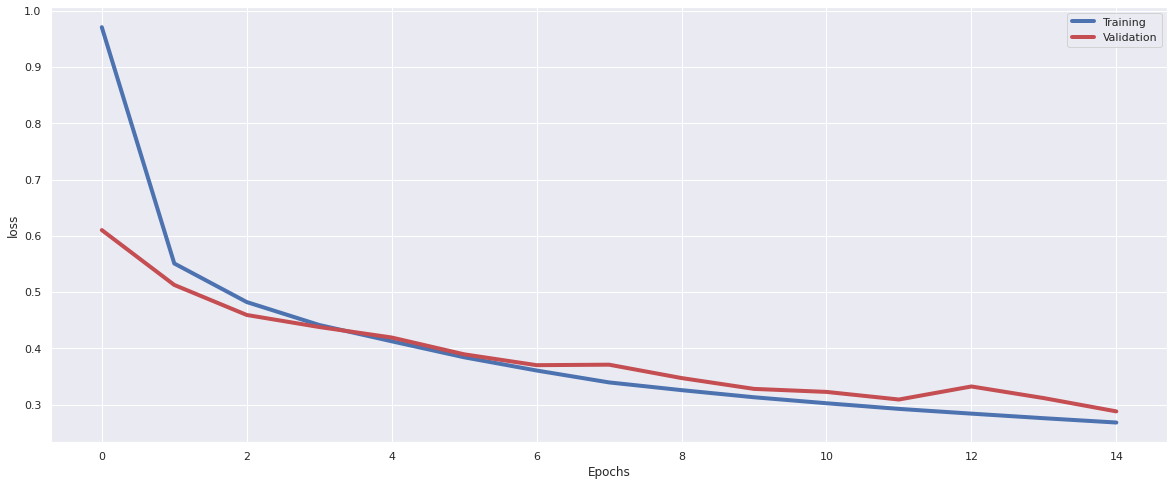

In [17]:
plot_history(history,plot_type='loss')

In [18]:
def convert_predictions(predictions):
  output = np.argmax(predictions,axis=1)
  return output

In [19]:
predictions = model_1.predict(X_test)

313/313 [==============================] - 2s 7ms/step


In [20]:
print('Weighted F1-score is %.2f' %f1_score(y_test, convert_predictions(predictions), average='weighted'))

Weighted F1-score is 0.89


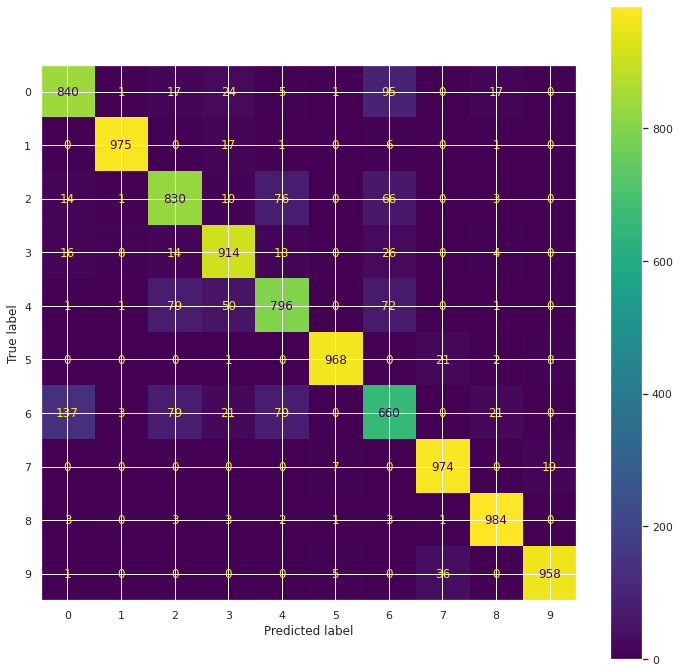

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(12, 12))
ConfusionMatrixDisplay.from_predictions(y_test, convert_predictions(predictions),ax=ax)
plt.show()

In [22]:
layers_list_2 = ['Conv2D_3x3_10_1','MaxPooling2D_2x2_0','Conv2D_3x3_20_1','AveragePooling2D_2x2_1', 'Conv2D_3x3_30_1', 'MaxPooling2D_2x2_0','Flatten','Dense_30']

model_2 = create_model(hidden_layers=layers_list_2,activation_func='sigmoid',l1_reg=0,l2_reg=0)
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 10)        100       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 10)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 20)        1820      
                                                                 
 average_pooling2d_1 (Averag  (None, 10, 10, 20)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 30)          5430      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 30)        

In [23]:
history = model_2.fit(X_train, y_train_enc, 
                    batch_size = 16, 
                    epochs = 15, 
                    validation_split=0.2,
                    callbacks=[early_stopping]
                    )

Epoch 1/15
3000/3000 [==============================] - 43s 14ms/step - loss: 1.0358 - accuracy: 0.6312 - val_loss: 0.6681 - val_accuracy: 0.7538
Epoch 2/15
3000/3000 [==============================] - 38s 13ms/step - loss: 0.6044 - accuracy: 0.7702 - val_loss: 0.5356 - val_accuracy: 0.7979
Epoch 3/15
3000/3000 [==============================] - 39s 13ms/step - loss: 0.5161 - accuracy: 0.8059 - val_loss: 0.5177 - val_accuracy: 0.7953
Epoch 4/15
3000/3000 [==============================] - 42s 14ms/step - loss: 0.4643 - accuracy: 0.8287 - val_loss: 0.4450 - val_accuracy: 0.8379
Epoch 5/15
3000/3000 [==============================] - 38s 13ms/step - loss: 0.4327 - accuracy: 0.8412 - val_loss: 0.4260 - val_accuracy: 0.8408
Epoch 6/15
3000/3000 [==============================] - 41s 14ms/step - loss: 0.4059 - accuracy: 0.8500 - val_loss: 0.4083 - val_accuracy: 0.8469
Epoch 7/15
3000/3000 [==============================] - 39s 13ms/step - loss: 0.3881 - accuracy: 0.8567 - val_loss: 0.4090 -

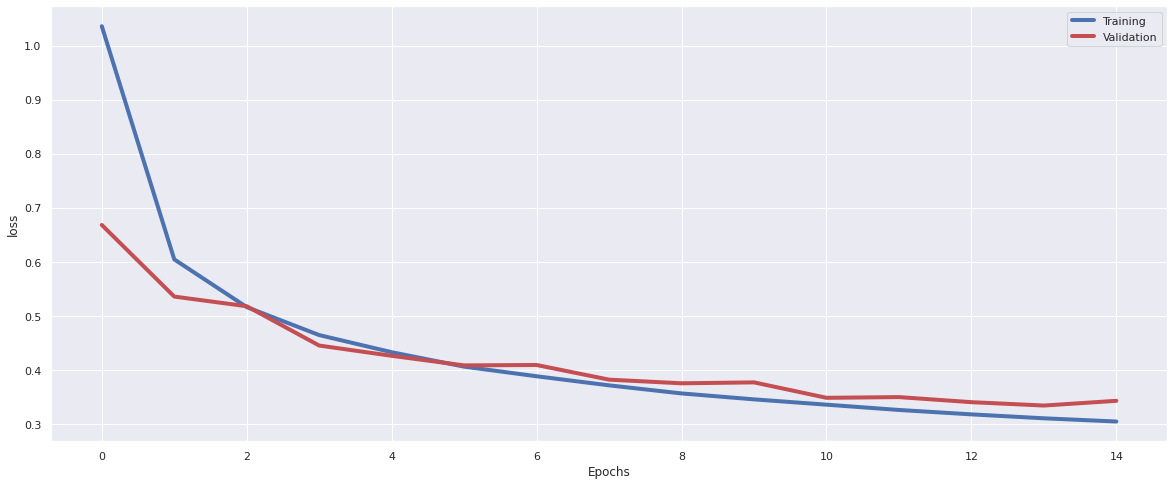

In [24]:
plot_history(history,plot_type='loss')

In [25]:
def convert_predictions(predictions):
  output = np.argmax(predictions,axis=1)
  return output

In [26]:
predictions = model_2.predict(X_test)

313/313 [==============================] - 3s 8ms/step


In [27]:
print('Weighted F1-score is %.2f' %f1_score(y_test, convert_predictions(predictions), average='weighted'))

Weighted F1-score is 0.87


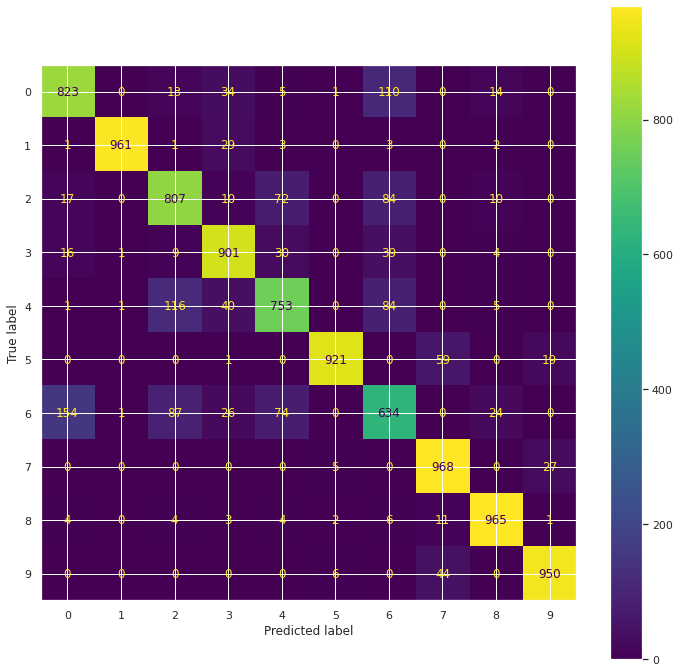

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(12, 12))
ConfusionMatrixDisplay.from_predictions(y_test, convert_predictions(predictions),ax=ax)
plt.show()

In [29]:
layers_list_3 = ['Conv2D_3x3_10_1','AveragePooling2D_2x2_1','Conv2D_3x3_20_1','MaxPooling2D_2x2_1', 'Conv2D_3x3_30_1', 'MaxPooling2D_2x2_1', 'Conv2D_3x3_40_1', 'MaxPooling2D_2x2_0', 'Flatten','Dense_30']

model_3 = create_model(hidden_layers=layers_list_3,activation_func='sigmoid',l1_reg=0,l2_reg=0)
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 26, 26, 10)        100       
                                                                 
 average_pooling2d_2 (Averag  (None, 25, 25, 10)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_6 (Conv2D)           (None, 23, 23, 20)        1820      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 22, 22, 20)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 20, 20, 30)        5430      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 19, 19, 30)      

In [30]:
history = model_3.fit(X_train, y_train_enc, 
                    batch_size = 16, 
                    epochs = 15, 
                    validation_split=0.2,
                    callbacks=[early_stopping]
                    )

Epoch 1/15
3000/3000 [==============================] - 144s 48ms/step - loss: 1.0328 - accuracy: 0.6289 - val_loss: 0.6604 - val_accuracy: 0.7535
Epoch 2/15
3000/3000 [==============================] - 143s 48ms/step - loss: 0.6395 - accuracy: 0.7568 - val_loss: 0.5922 - val_accuracy: 0.7761
Epoch 3/15
3000/3000 [==============================] - 146s 49ms/step - loss: 0.5789 - accuracy: 0.7789 - val_loss: 0.5807 - val_accuracy: 0.7832
Epoch 4/15
3000/3000 [==============================] - 145s 48ms/step - loss: 0.5329 - accuracy: 0.7978 - val_loss: 0.5144 - val_accuracy: 0.8044
Epoch 5/15
3000/3000 [==============================] - 146s 49ms/step - loss: 0.4937 - accuracy: 0.8144 - val_loss: 0.4837 - val_accuracy: 0.8233
Epoch 6/15
3000/3000 [==============================] - 149s 50ms/step - loss: 0.4611 - accuracy: 0.8275 - val_loss: 0.4557 - val_accuracy: 0.8296
Epoch 7/15
3000/3000 [==============================] - 145s 48ms/step - loss: 0.4317 - accuracy: 0.8391 - val_loss: 0

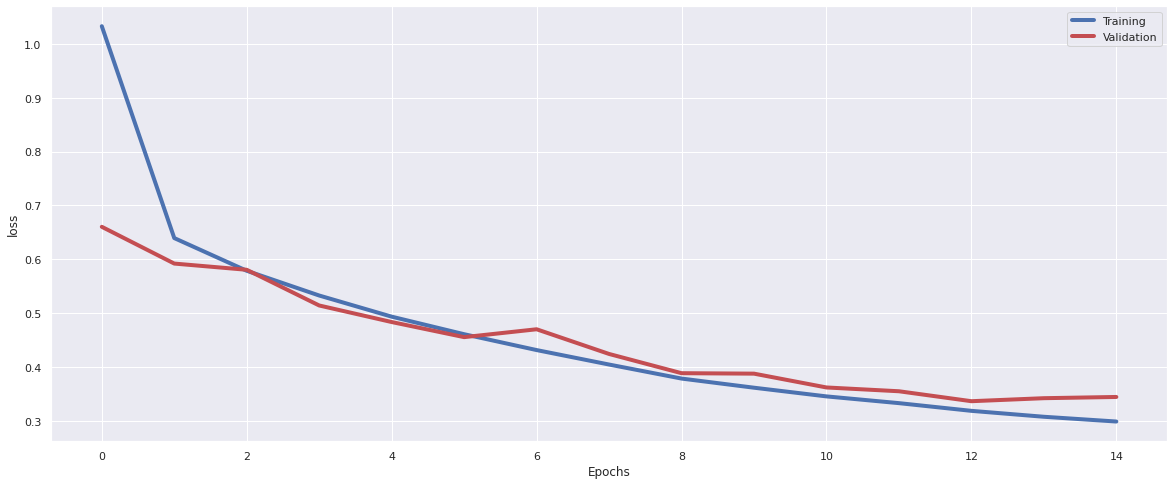

In [31]:
plot_history(history,plot_type='loss')

In [32]:
def convert_predictions(predictions):
  output = np.argmax(predictions,axis=1)
  return output

In [33]:
predictions = model_3.predict(X_test)

313/313 [==============================] - 7s 24ms/step


In [34]:
print('Weighted F1-score is %.2f' %f1_score(y_test, convert_predictions(predictions), average='weighted'))

Weighted F1-score is 0.87


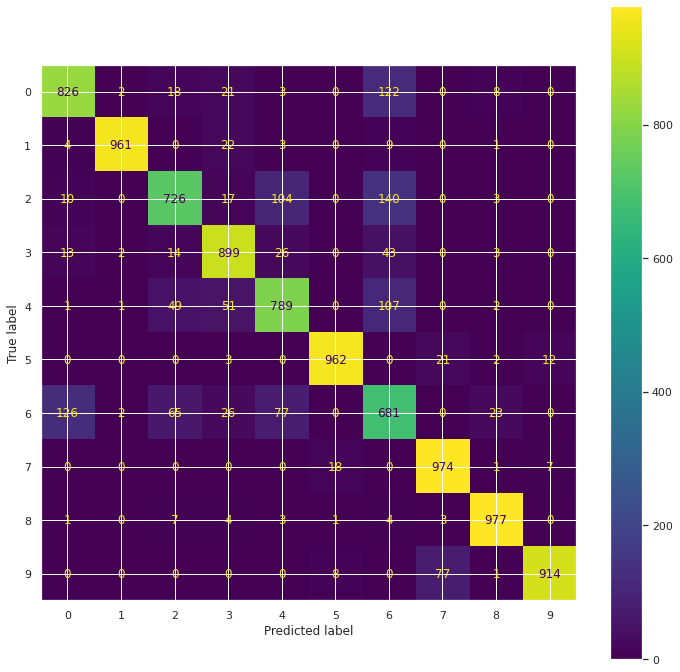

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(12, 12))
ConfusionMatrixDisplay.from_predictions(y_test, convert_predictions(predictions),ax=ax)
plt.show()

In [36]:
#@title K-Fold Validation Function

from sklearn.model_selection import KFold#, StratifiedKFold

def kfold_validation(no_folds: int=3, plot_results: bool=True,
                     model_params: dict={},training_params: dict={}):
  validation_set_accuracy = []
  models = []

  if plot_results:
    verbose=2
  else:
    verbose=0

  itr = 0
  kf = KFold(n_splits=no_folds)
  for train_index, val_index in kf.split(X_train,y_train):
    train_set, y_train_set = X_train[train_index,:,:,:], y_train_enc[train_index]
    val_set,y_val = X_train[val_index,:,:,:], y_train_enc[val_index]
    
    # First, create a new model
    model = create_model(**model_params)
    #model.summary()

    # Finally, let's fit the model
    history = model.fit(train_set, y_train_set, 
                      validation_data=(val_set,y_val),
                      callbacks=[early_stopping],
                      verbose=verbose,
                      **training_params,
                      )
  
    
    # Finally, let's 
    pred_val = model.predict(val_set)
    f1 = f1_score(convert_predictions(y_val), convert_predictions(pred_val), average='weighted')
    
    validation_set_accuracy.append(f1)
    models.append(model)

    # Plot the results
    if plot_results:
      plot_history(history,plot_type='acc')

  
  # Convert to numpy array
  validation_set_accuracy = np.array(validation_set_accuracy)

  # Return the best model (as an example)
  ind = np.argmax(validation_set_accuracy)
  best_model = models[ind]

  # Delete remaining models 
  models.remove(best_model)
  for m in models:
    del m

  # Print the reults
  if plot_results:
    print('Average F1-Score over validation set is %.2f' %validation_set_accuracy.mean())
    print('STD of F1-Score over validation set is %.2f' %validation_set_accuracy.std())
  return best_model,validation_set_accuracy.mean(),validation_set_accuracy.std()

In [ ]:
#@title Parameters Effect Evalution Function

def evaluate_efect_param(parameter_type: str='kfold', parameter_name: str='', values_list: list=[]):
  scores_val = []
  scores_test = []
  models = []
  for val in values_list:
      if parameter_type == 'kfold':
        kfold_params[parameter_name] = val
      elif parameter_type == 'model_params':
        kfold_params['model_params'][parameter_name] = val
      elif parameter_type == 'training_params':
        kfold_params['training_params'][parameter_name] = val
        
      model,validation_set_accuracy_mean,validation_set_accuracy_std = kfold_validation(**kfold_params)
      
      scores_val.append(validation_set_accuracy_mean)

      predictions = model.predict(X_test)
      score_test = f1_score(y_test, convert_predictions(predictions), average='weighted')
      scores_test.append(score_test)

      models.append(model)
      print('Val: %s, Validation Score: %.3f, Test Score: %.3f' %(str(val),validation_set_accuracy_mean,score_test))

      
  # Plot the results
  plt.figure(figsize=(20,8))
  str_values_list = []
  for v in values_list:
    str_values_list.append(str(v))

  plt.plot(str_values_list,scores_test,lw=5)
  plt.plot(str_values_list,scores_val,lw=5,color='orange')
  plt.xlabel(parameter_name)
  plt.ylabel('F1-Score')
  plt.legend(['F1: Test Set','F1: Validation Set'])
  plt.show()

  # Get the best model
  ind = np.argmax(scores_val)
  best_model = models[ind]
  
  best_val = values_list[np.argmax(scores_val)]

  # Delete remaining models 
  models.remove(best_model)
  for m in models:
    del m

  return best_model,best_val

In [ ]:
#@title K-Fold Params
kfold_params = {
    'no_folds': 3,
    'plot_results': False,
    'model_params': {
      'hidden_layers': ['Conv2D_3x3_10_1','MaxPooling2D_2x2_0','Conv2D_5x5_20_1','AveragePooling2D_2x2_1','Flatten','Dense_30'],
      'activation_func': 'relu',
      'l1_reg': 0,
      'l2_reg': 0,
      'learning_rate': 0.001,
      'learning_rate_decay': 0.9,
      'dropout_rate':0.01,
      'weight_initializer': 'GlorotNormal',
      'optimizer_name': 'adam',
      'regularization_type': 'kernel_regularizer',
  },
  'training_params': {
    'batch_size': 32,
    'epochs': 5
  }
}

In [ ]:
model,validation_set_accuracy_mean,validation_set_accuracy_std = kfold_validation(**kfold_params)

625/625 [==============================] - 4s 6ms/step


In [ ]:
print(validation_set_accuracy_mean,validation_set_accuracy_std)

0.8894750039843492 0.0027580998513305303


In [ ]:
kfold_params['plot_results'] = False

### Fine tuning

As we have 3 different models we will fine tune all of the mentioned parameters for each model separately.

#### The First Model

313/313 [==============================] - 2s 6ms/step
Val: ['Conv2D_3x3_10_1', 'MaxPooling2D_2x2_0', 'Conv2D_3x3_20_1', 'AveragePooling2D_2x2_1', 'Flatten', 'Dense_30'], Validation Score: 0.883, Test Score: 0.887
313/313 [==============================] - 2s 6ms/step
Val: ['Conv2D_5x5_10_1', 'MaxPooling2D_2x2_0', 'Conv2D_5x5_20_1', 'AveragePooling2D_2x2_1', 'Flatten', 'Dense_30'], Validation Score: 0.881, Test Score: 0.880
313/313 [==============================] - 2s 6ms/step
Val: ['Conv2D_7x7_10_1', 'MaxPooling2D_2x2_0', 'Conv2D_7x7_20_1', 'AveragePooling2D_2x2_1', 'Flatten', 'Dense_30'], Validation Score: 0.874, Test Score: 0.866


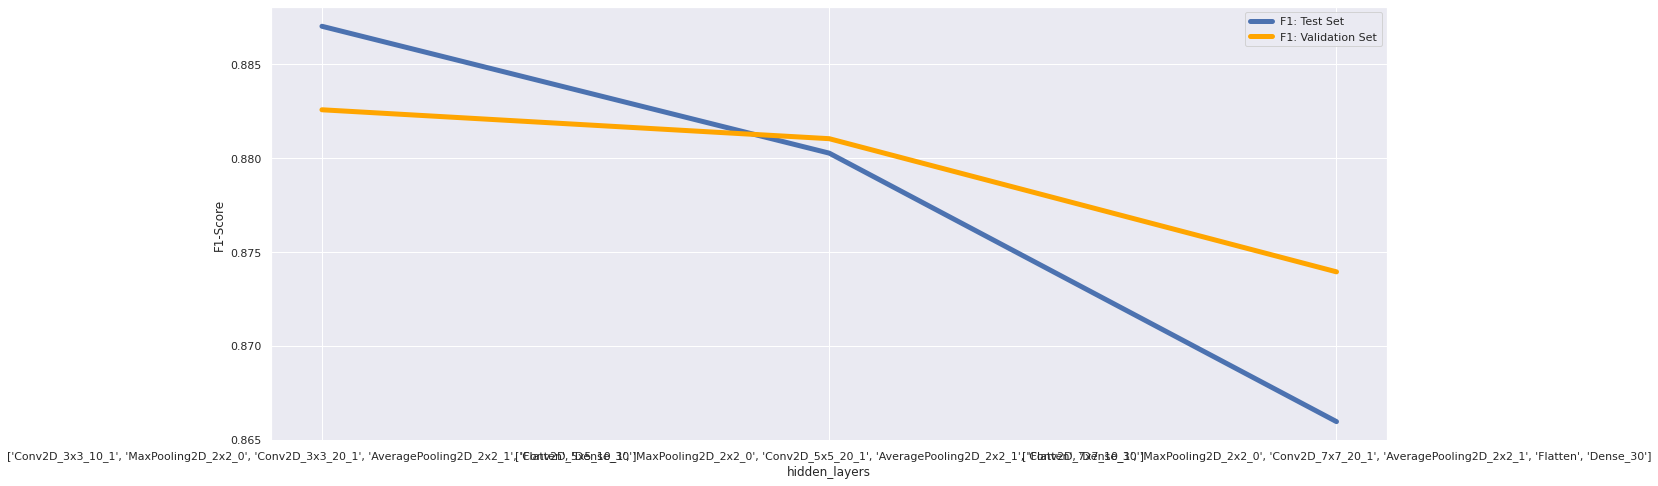

In [ ]:
#@title Effects of Kernel Size

# Kernel size of 3
values_list = [['Conv2D_3x3_10_1','MaxPooling2D_2x2_0','Conv2D_3x3_20_1','AveragePooling2D_2x2_1','Flatten','Dense_30']]

# Kernel size of 4
values_list += [['Conv2D_5x5_10_1','MaxPooling2D_2x2_0','Conv2D_5x5_20_1','AveragePooling2D_2x2_1','Flatten','Dense_30']]

# Kernel size of 5
values_list += [['Conv2D_7x7_10_1','MaxPooling2D_2x2_0','Conv2D_7x7_20_1','AveragePooling2D_2x2_1','Flatten','Dense_30']]

model,best_architecture = evaluate_efect_param(parameter_type='model_params',parameter_name='hidden_layers',values_list=values_list)
kfold_params['model_params']['hidden_layers'] = best_architecture


313/313 [==============================] - 4s 12ms/step
Val: ['Conv2D_3x3_10_1', 'MaxPooling2D_2x2_1', 'Conv2D_3x3_20_1', 'AveragePooling2D_2x2_1', 'Flatten', 'Dense_30'], Validation Score: 0.905, Test Score: 0.900
313/313 [==============================] - 1s 3ms/step
Val: ['Conv2D_3x3_10_2', 'MaxPooling2D_2x2_1', 'Conv2D_3x3_20_2', 'AveragePooling2D_2x2_1', 'Flatten', 'Dense_30'], Validation Score: 0.851, Test Score: 0.854
313/313 [==============================] - 1s 2ms/step
Val: ['Conv2D_3x3_10_3', 'MaxPooling2D_2x2_1', 'Conv2D_3x3_20_3', 'AveragePooling2D_2x2_1', 'Flatten', 'Dense_30'], Validation Score: 0.761, Test Score: 0.772


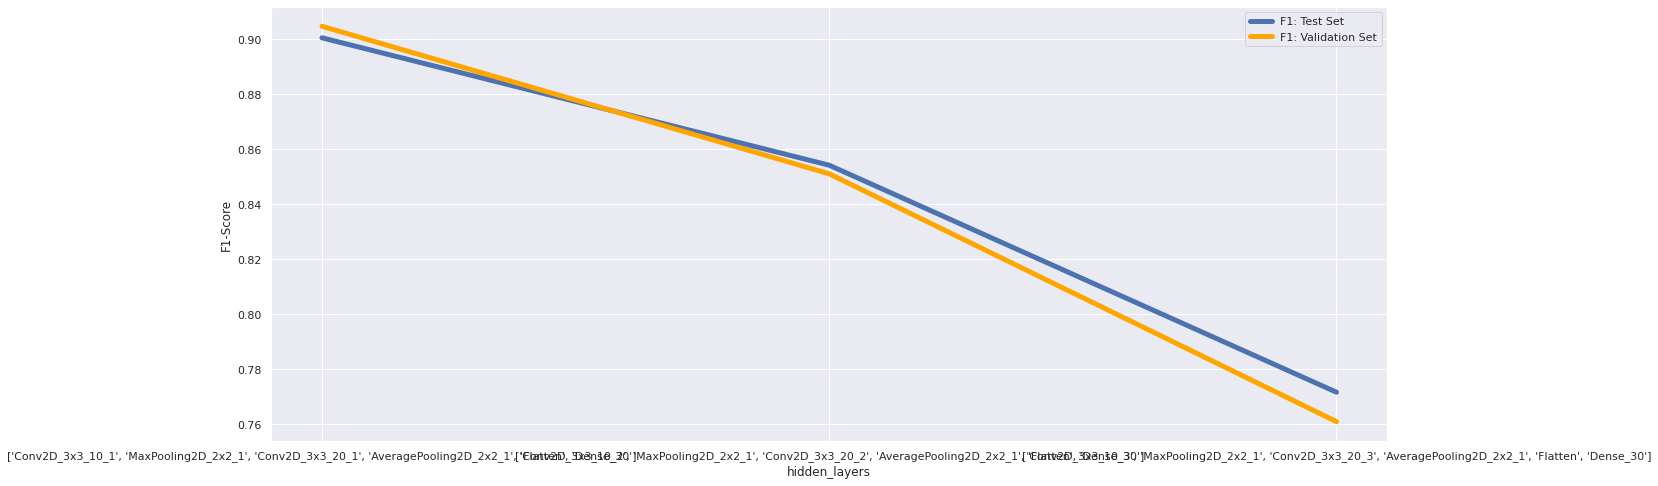

In [ ]:
#@title Effects of Stride

# Stride 1
values_list = [['Conv2D_3x3_10_1','MaxPooling2D_2x2_1','Conv2D_3x3_20_1','AveragePooling2D_2x2_1','Flatten','Dense_30']]

# Stride 2
values_list += [['Conv2D_3x3_10_2','MaxPooling2D_2x2_1','Conv2D_3x3_20_2','AveragePooling2D_2x2_1','Flatten','Dense_30']]

# Stride 3
values_list += [['Conv2D_3x3_10_3','MaxPooling2D_2x2_1','Conv2D_3x3_20_3','AveragePooling2D_2x2_1','Flatten','Dense_30']]

model,best_architecture = evaluate_efect_param(parameter_type='model_params',parameter_name='hidden_layers',values_list=values_list)
kfold_params['model_params']['hidden_layers'] = best_architecture


313/313 [==============================] - 4s 11ms/step
Val: ['Conv2D_3x3_10_1', 'MaxPooling2D_2x2_1', 'Conv2D_3x3_20_1', 'AveragePooling2D_2x2_1', 'Flatten', 'Dense_30'], Validation Score: 0.902, Test Score: 0.898
313/313 [==============================] - 3s 8ms/step
Val: ['Conv2D_3x3_10_1', 'MaxPooling2D_3x3_1', 'Conv2D_3x3_20_2', 'AveragePooling2D_3x3_1', 'Flatten', 'Dense_30'], Validation Score: 0.869, Test Score: 0.858
313/313 [==============================] - 3s 10ms/step
Val: ['Conv2D_3x3_10_1', 'MaxPooling2D_5x5_1', 'Conv2D_3x3_20_3', 'AveragePooling2D_5x5_1', 'Flatten', 'Dense_30'], Validation Score: 0.791, Test Score: 0.787


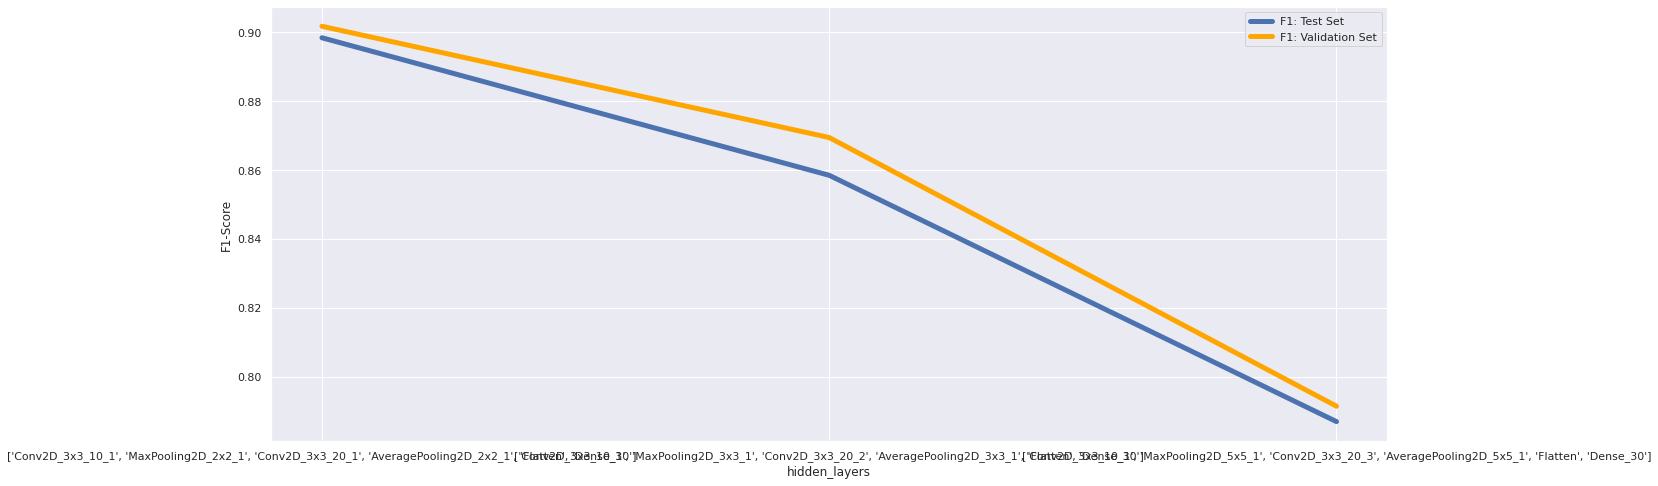

In [ ]:
#@title Effects of Pooling Size

# Pooling Size 2
values_list = [['Conv2D_3x3_10_1','MaxPooling2D_2x2_1','Conv2D_3x3_20_1','AveragePooling2D_2x2_1','Flatten','Dense_30']]

# Pooling Size 3
values_list += [['Conv2D_3x3_10_1','MaxPooling2D_3x3_1','Conv2D_3x3_20_2','AveragePooling2D_3x3_1','Flatten','Dense_30']]

# Pooling Size 5
values_list += [['Conv2D_3x3_10_1','MaxPooling2D_5x5_1','Conv2D_3x3_20_3','AveragePooling2D_5x5_1','Flatten','Dense_30']]

model,best_architecture = evaluate_efect_param(parameter_type='model_params',parameter_name='hidden_layers',values_list=values_list)
kfold_params['model_params']['hidden_layers'] = best_architecture


313/313 [==============================] - 4s 11ms/step
Val: ['Conv2D_3x3_10_1', 'MaxPooling2D_2x2_1', 'Conv2D_3x3_20_1', 'AveragePooling2D_2x2_1', 'Flatten', 'Dense_30'], Validation Score: 0.905, Test Score: 0.901
313/313 [==============================] - 2s 5ms/step
Val: ['Conv2D_3x3_10_1', 'MaxPooling2D_2x2_3', 'Conv2D_3x3_20_2', 'AveragePooling2D_2x2_3', 'Flatten', 'Dense_30'], Validation Score: 0.764, Test Score: 0.760
313/313 [==============================] - 2s 5ms/step
Val: ['Conv2D_3x3_10_1', 'MaxPooling2D_2x2_4', 'Conv2D_3x3_20_3', 'AveragePooling2D_2x2_4', 'Flatten', 'Dense_30'], Validation Score: 0.795, Test Score: 0.801


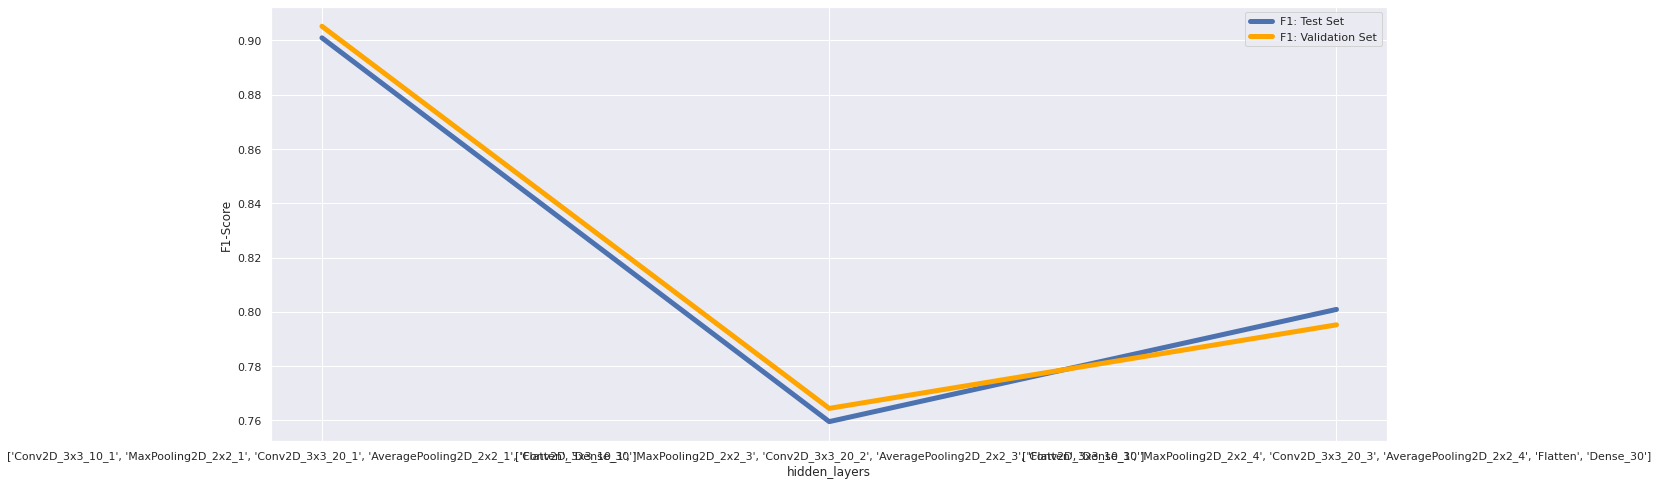

In [ ]:
#@title Effects of Pooling Stride

# Pooling Stride 1
values_list = [['Conv2D_3x3_10_1','MaxPooling2D_2x2_1','Conv2D_3x3_20_1','AveragePooling2D_2x2_1','Flatten','Dense_30']]

# Pooling Stride 3
values_list += [['Conv2D_3x3_10_1','MaxPooling2D_2x2_3','Conv2D_3x3_20_2','AveragePooling2D_2x2_3','Flatten','Dense_30']]

# Pooling Stride 4
values_list += [['Conv2D_3x3_10_1','MaxPooling2D_2x2_4','Conv2D_3x3_20_3','AveragePooling2D_2x2_4','Flatten','Dense_30']]

model,best_architecture = evaluate_efect_param(parameter_type='model_params',parameter_name='hidden_layers',values_list=values_list)
kfold_params['model_params']['hidden_layers'] = best_architecture

#### The Second Model

313/313 [==============================] - 2s 7ms/step
Val: ['Conv2D_3x3_10_1', 'MaxPooling2D_2x2_0', 'Conv2D_3x3_20_1', 'AveragePooling2D_2x2_1', 'Conv2D_3x3_30_1', 'MaxPooling2D_2x2_0', 'Flatten', 'Dense_30'], Validation Score: 0.877, Test Score: 0.877
313/313 [==============================] - 2s 7ms/step
Val: ['Conv2D_4x4_10_1', 'MaxPooling2D_2x2_0', 'Conv2D_4x4_20_1', 'AveragePooling2D_2x2_1', 'Conv2D_4x4_30_1', 'MaxPooling2D_2x2_0', 'Flatten', 'Dense_30'], Validation Score: 0.852, Test Score: 0.853
313/313 [==============================] - 2s 6ms/step
Val: ['Conv2D_5x5_10_1', 'MaxPooling2D_2x2_0', 'Conv2D_5x5_20_1', 'AveragePooling2D_2x2_1', 'Conv2D_5x5_30_1', 'MaxPooling2D_2x2_0', 'Flatten', 'Dense_30'], Validation Score: 0.862, Test Score: 0.863


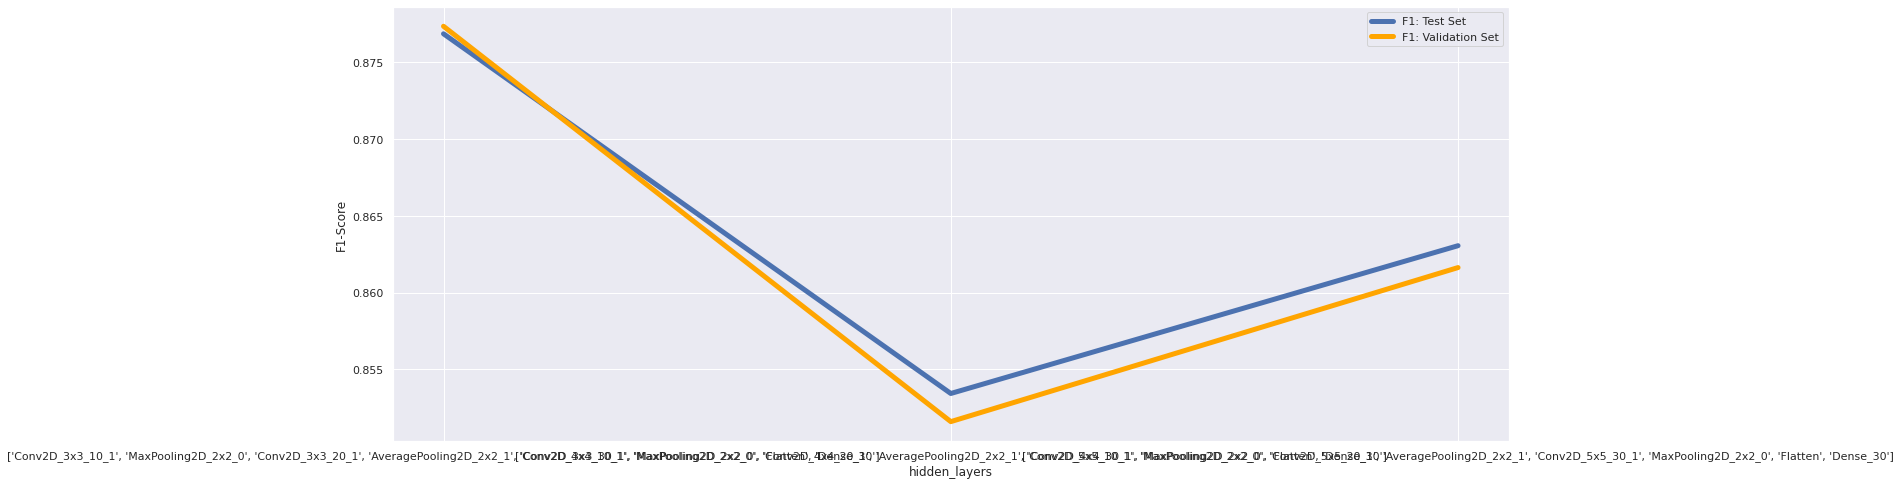

In [ ]:
#@title Effects of Kernel Size

# Kernel size of 3
values_list = [['Conv2D_3x3_10_1','MaxPooling2D_2x2_0','Conv2D_3x3_20_1','AveragePooling2D_2x2_1', 'Conv2D_3x3_30_1', 'MaxPooling2D_2x2_0','Flatten','Dense_30']]

# Kernel size of 4
values_list += [['Conv2D_4x4_10_1','MaxPooling2D_2x2_0','Conv2D_4x4_20_1','AveragePooling2D_2x2_1', 'Conv2D_4x4_30_1', 'MaxPooling2D_2x2_0','Flatten','Dense_30']]

# Kernel size of 5
values_list += [['Conv2D_5x5_10_1','MaxPooling2D_2x2_0','Conv2D_5x5_20_1','AveragePooling2D_2x2_1', 'Conv2D_5x5_30_1', 'MaxPooling2D_2x2_0','Flatten','Dense_30']]


model,best_architecture = evaluate_efect_param(parameter_type='model_params',parameter_name='hidden_layers',values_list=values_list)
kfold_params['model_params']['hidden_layers'] = best_architecture


313/313 [==============================] - 2s 7ms/step
Val: ['Conv2D_3x3_10_1', 'MaxPooling2D_2x2_0', 'Conv2D_3x3_20_1', 'AveragePooling2D_2x2_1', 'Conv2D_3x3_30_1', 'MaxPooling2D_2x2_0', 'Flatten', 'Dense_30'], Validation Score: 0.884, Test Score: 0.880
313/313 [==============================] - 2s 6ms/step
Val: ['Conv2D_3x3_10_1', 'MaxPooling2D_2x2_0', 'Conv2D_3x3_20_2', 'AveragePooling2D_2x2_1', 'Conv2D_3x3_30_2', 'MaxPooling2D_2x2_0', 'Flatten', 'Dense_30'], Validation Score: 0.848, Test Score: 0.848
313/313 [==============================] - 2s 6ms/step
Val: ['Conv2D_3x3_10_1', 'MaxPooling2D_2x2_0', 'Conv2D_3x3_20_1', 'AveragePooling2D_2x2_1', 'Conv2D_3x3_30_3', 'MaxPooling2D_2x2_0', 'Flatten', 'Dense_30'], Validation Score: 0.822, Test Score: 0.823


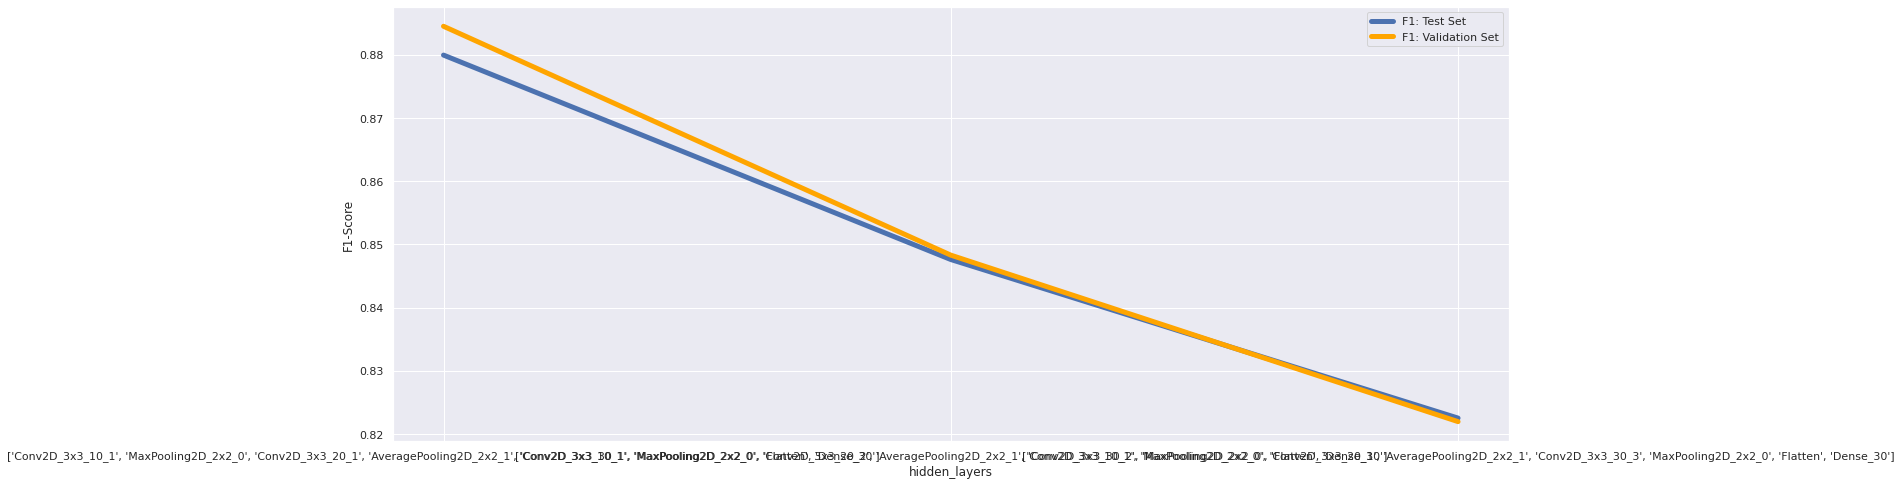

In [ ]:
#@title Effects of Stride

# Stride 1
values_list = [['Conv2D_3x3_10_1','MaxPooling2D_2x2_0','Conv2D_3x3_20_1','AveragePooling2D_2x2_1', 'Conv2D_3x3_30_1', 'MaxPooling2D_2x2_0','Flatten','Dense_30']]

# Stride 2
values_list += [['Conv2D_3x3_10_1','MaxPooling2D_2x2_0','Conv2D_3x3_20_2','AveragePooling2D_2x2_1', 'Conv2D_3x3_30_2', 'MaxPooling2D_2x2_0','Flatten','Dense_30']]

# Stride 3
values_list += [['Conv2D_3x3_10_1','MaxPooling2D_2x2_0','Conv2D_3x3_20_1','AveragePooling2D_2x2_1', 'Conv2D_3x3_30_3', 'MaxPooling2D_2x2_0','Flatten','Dense_30']]


model,best_architecture = evaluate_efect_param(parameter_type='model_params',parameter_name='hidden_layers',values_list=values_list)
kfold_params['model_params']['hidden_layers'] = best_architecture


#### The Third Model


In [ ]:
#@title Effects of Kernel Size

# Kernel size of 3
values_list = [['Conv2D_3x3_10_1','AveragePooling2D_2x2_1','Conv2D_3x3_20_1','MaxPooling2D_2x2_1', 'Conv2D_3x3_30_1', 'MaxPooling2D_2x2_1', 'Conv2D_3x3_40_1', 'MaxPooling2D_2x2_0', 'Flatten','Dense_30']]

# Kernel size of 5
values_list += [['Conv2D_5x5_10_1','AveragePooling2D_2x2_1','Conv2D_5x5_20_1','MaxPooling2D_2x2_1', 'Conv2D_5x5_30_1', 'MaxPooling2D_2x2_1', 'Conv2D_5x5_40_1', 'MaxPooling2D_2x2_0', 'Flatten','Dense_30']]

# Kernel size of 7
#values_list += [['Conv2D_7x7_10_1','AveragePooling2D_2x2_1','Conv2D_7x7_20_1','MaxPooling2D_2x2_1', 'Conv2D_7x7_30_1', 'MaxPooling2D_2x2_1', 'Conv2D_7x7_40_1', 'MaxPooling2D_2x2_0', 'Flatten','Dense_30']]

model,best_architecture = evaluate_efect_param(parameter_type='model_params',parameter_name='hidden_layers',values_list=values_list)
kfold_params['model_params']['hidden_layers'] = best_architecture


In [ ]:
#@title Effects of Stride

# Stride 1
values_list = [['Conv2D_3x3_10_1','AveragePooling2D_2x2_1','Conv2D_3x3_20_1','MaxPooling2D_2x2_1', 'Conv2D_3x3_30_1', 'MaxPooling2D_2x2_1', 'Conv2D_3x3_40_1', 'MaxPooling2D_2x2_0', 'Flatten','Dense_30']]

# Stride 2
values_list += [['Conv2D_3x3_10_1','AveragePooling2D_2x2_1','Conv2D_3x3_20_1','MaxPooling2D_2x2_1', 'Conv2D_3x3_30_2', 'MaxPooling2D_2x2_1', 'Conv2D_3x3_40_2', 'MaxPooling2D_2x2_0', 'Flatten','Dense_30']]

# Stride 3
values_list += [['Conv2D_3x3_10_1','AveragePooling2D_2x2_1','Conv2D_3x3_20_1','MaxPooling2D_2x2_1', 'Conv2D_3x3_30_3', 'MaxPooling2D_2x2_1', 'Conv2D_3x3_40_3', 'MaxPooling2D_2x2_0', 'Flatten','Dense_30']]

model,best_architecture = evaluate_efect_param(parameter_type='model_params',parameter_name='hidden_layers',values_list=values_list)
kfold_params['model_params']['hidden_layers'] = best_architecture


## Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator#, array_to_img, img_to_array, load_img


In [ ]:
def plot_generated_images(image_generator,no_rows: int=6,no_columns: int=6):
  fig, ax = plt.subplots(nrows=no_rows, ncols=no_rows, figsize=(no_rows,no_columns))
  itr = 0
  for i in range(0,no_rows):
    for j in range(0,no_columns):  
      batch = image_generator.next()
      # convert to unsigned integers for viewing
      image = batch[0].astype('uint8')
      #pdb.set_trace()
      # plot image
      image = image.reshape((image.shape[0],image.shape[1]))
      ax[i,j].imshow(image, cmap='gray')
      ax[i,j].axis('off')
  
plt.show()

In [ ]:
# Load an image
x = X_train[1,:,:]
x = 255*x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 28,28,1)

In [ ]:
x.shape

(1, 28, 28, 1)

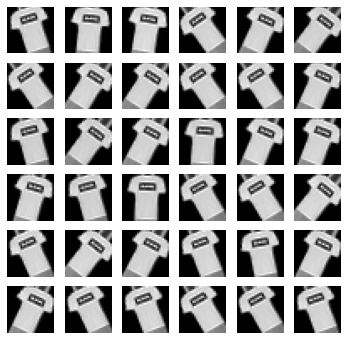

In [ ]:
datagen = ImageDataGenerator(rotation_range=40,fill_mode='nearest')
image_generator = datagen.flow(x, batch_size=1)
plot_generated_images(image_generator)

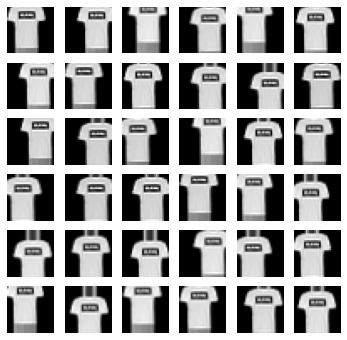

In [ ]:
datagen = ImageDataGenerator(width_shift_range=0.2,height_shift_range=0.2,fill_mode='nearest')
image_generator = datagen.flow(x, batch_size=1)
plot_generated_images(image_generator)

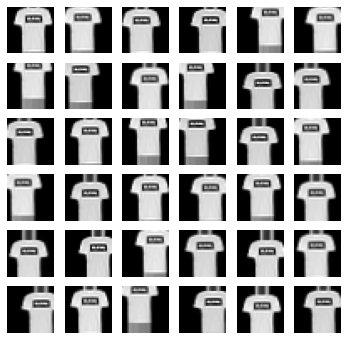

In [ ]:
datagen = ImageDataGenerator(shear_range=0.2,fill_mode='nearest')
it = datagen.flow(x, batch_size=1)
plot_generated_images(image_generator)

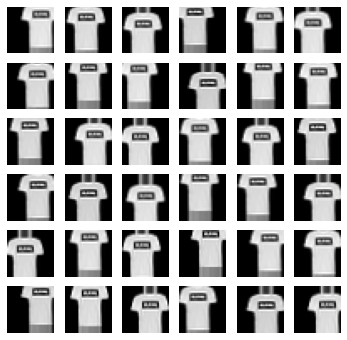

In [ ]:
datagen = ImageDataGenerator(zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')
it = datagen.flow(x, batch_size=1)
plot_generated_images(image_generator)

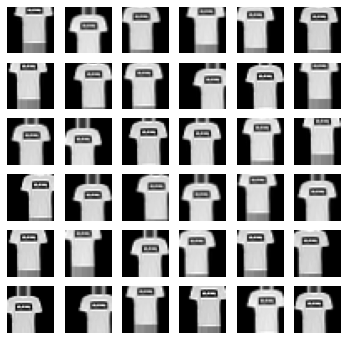

In [ ]:
datagen = ImageDataGenerator(featurewise_center=True)
it = datagen.flow(x, batch_size=1)
plot_generated_images(image_generator)

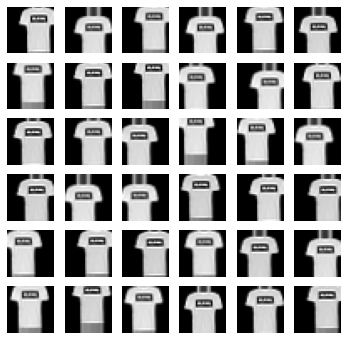

In [ ]:
datagen = ImageDataGenerator(featurewise_std_normalization=True)
it = datagen.flow(x, batch_size=1)
plot_generated_images(image_generator)

### Putting it Altogether
Let's combine all the options and create a complete image generator.

In [ ]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        featurewise_center=True,
        featurewise_std_normalization=True,
        fill_mode='nearest',
        validation_split=0.2
        )

#test_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
train_iterator = train_datagen.flow(X_train, y_train_enc,subset='training',batch_size=32)
val_iterator = train_datagen.flow(X_train, y_train_enc,subset='validation',batch_size=32)

In [ ]:
history = model_1.fit_generator(
      train_iterator,
      validation_data=val_iterator, 
      callbacks=[early_stopping],
      steps_per_epoch=len(train_iterator),
      validation_steps=len(val_iterator),
      verbose=2,
      epochs=15,
)

Epoch 1/15
1500/1500 - 41s - loss: 1.4913 - accuracy: 0.4747 - val_loss: 1.2483 - val_accuracy: 0.5483 - 41s/epoch - 27ms/step
Epoch 2/15
1500/1500 - 39s - loss: 1.1610 - accuracy: 0.5774 - val_loss: 1.0894 - val_accuracy: 0.5985 - 39s/epoch - 26ms/step
Epoch 3/15
1500/1500 - 40s - loss: 1.0492 - accuracy: 0.6153 - val_loss: 1.0309 - val_accuracy: 0.6266 - 40s/epoch - 27ms/step
Epoch 4/15
1500/1500 - 39s - loss: 0.9836 - accuracy: 0.6384 - val_loss: 0.9678 - val_accuracy: 0.6420 - 39s/epoch - 26ms/step
Epoch 5/15
1500/1500 - 40s - loss: 0.9335 - accuracy: 0.6544 - val_loss: 0.9197 - val_accuracy: 0.6610 - 40s/epoch - 26ms/step
Epoch 6/15
1500/1500 - 39s - loss: 0.9082 - accuracy: 0.6612 - val_loss: 0.8841 - val_accuracy: 0.6747 - 39s/epoch - 26ms/step
Epoch 7/15
1500/1500 - 40s - loss: 0.8683 - accuracy: 0.6767 - val_loss: 0.8997 - val_accuracy: 0.6560 - 40s/epoch - 26ms/step
Epoch 8/15
1500/1500 - 40s - loss: 0.8597 - accuracy: 0.6816 - val_loss: 0.8739 - val_accuracy: 0.6789 - 40s/ep

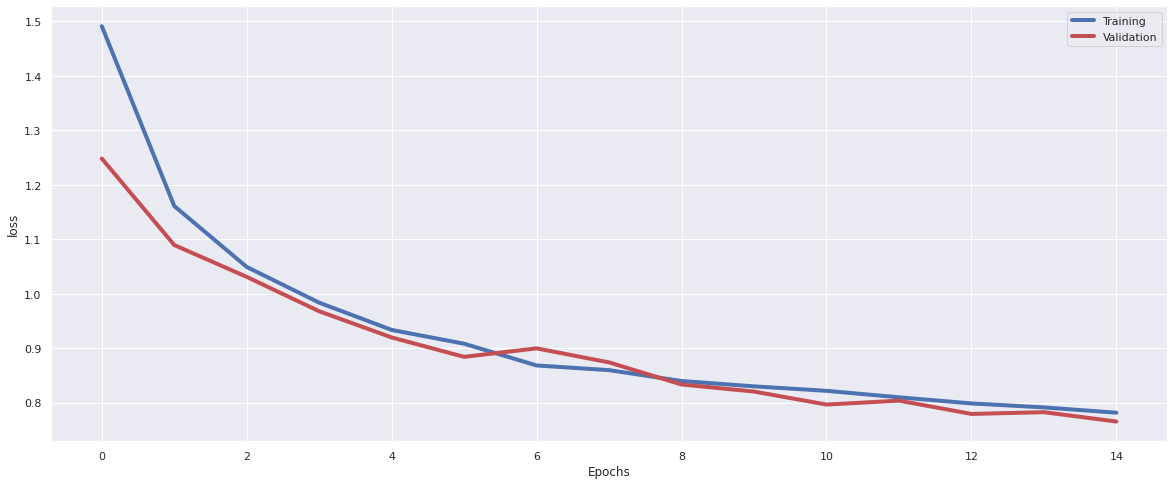

In [ ]:
plot_history(history,plot_type='loss')

In [ ]:
predictions = model.predict(X_test)
print('Weighted F1-score is %.2f' %f1_score(y_test, convert_predictions(predictions), average='weighted'))

313/313 [==============================] - 2s 7ms/step
Weighted F1-score is 0.88


In [ ]:
from sklearn.metrics import top_k_accuracy_score
print('Top-3accuracy %s' % top_k_accuracy_score(y_test, predictions, k=3))

Top-3accuracy 0.9882


In [ ]:
import cv2

IMG_SIZE = 32

def resize(img_array):
    tmp = np.empty((img_array.shape[0], IMG_SIZE, IMG_SIZE))

    for i in range(len(img_array)):
        img = img_array[i].reshape(28, 28).astype('uint8')
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img.astype('float32')/255
        tmp[i] = img
        
    return tmp

train_x_resize = resize(X_train)
test_x_resize = resize(X_test)

In [ ]:
train_x_final = np.stack((train_x_resize,)*3, axis=-1)
test_x_final = np.stack((test_x_resize,)*3, axis=-1)
print(train_x_final.shape)
print(test_x_final.shape)

(60000, 32, 32, 3)
(10000, 32, 32, 3)


### VGG19 Model

In [ ]:
from tensorflow.keras.applications import VGG19
def create_transfer_model(base_model,learning_rate=0.001,learning_rate_decay=0.9,no_classes=y_train_enc.shape[1]):
  model = tf.keras.Sequential()
  model.add(base_model)           #Adds the base model
  model.add(Flatten())
  model.add(Dense(128,activation=('relu')))
  model.add(Dropout(.2))
  model.add(Dense(no_classes,activation=('softmax'))) 

  model.compile(
          loss='categorical_crossentropy', 
          optimizer= tf.keras.optimizers.Adam(lr=learning_rate,beta_1=learning_rate_decay),
          metrics=['accuracy'],
          )
  return model


In [ ]:
base_model = VGG19(
    include_top=False,    # We do not include the top, because we just need the feature extraction layers
    weights='imagenet',
    input_shape=train_x_final.shape[1:],
    classes=y_train_enc.shape[1])

# We make the weight non-trainable to reduce the number of weights in the network
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model = create_transfer_model(base_model)
model.summary()

Model: "sequential_137"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_120 (Flatten)       (None, 512)               0         
                                                                 
 dense_240 (Dense)           (None, 128)               65664     
                                                                 
 dropout_88 (Dropout)        (None, 128)               0         
                                                                 
 dense_241 (Dense)           (None, 10)                1290      
                                                                 
Total params: 20,091,338
Trainable params: 66,954
Non-trainable params: 20,024,384
_________________________________________________________________


Now that we have the base model, let's train it and see what performance we get by training the last few layers.

In [ ]:
history = model.fit_generator(
      train_iterator,
      validation_data=val_iterator, 
      callbacks=[early_stopping],
      steps_per_epoch=len(train_iterator),
      validation_steps=len(val_iterator),
      verbose=1,
      epochs=10,
)

In [ ]:
predictions = model.predict(X_test)
print('Weighted F1-score is %.2f' %f1_score(y_test, convert_predictions(predictions), average='weighted'))

313/313 [==============================] - 138s 441ms/step
Weighted F1-score is 0.52


In [ ]:
print('Top-3accuracy %s' % top_k_accuracy_score(y_test, predictions, k=3))

Top-3accuracy 0.8313


In [ ]:
import copy
model_vgg = copy.deepcopy(model)

### ResNet Model
Next, we try the well know ResNet50 model. The steps are basically the same as above, except for the base model.

In [ ]:
from keras.applications import resnet

base_model = resnet.ResNet50(
    include_top=False,    # We do not include the top, because we just need the feature extraction layers
    weights='imagenet',
    input_shape=train_x_final.shape[1:],
    classes=y_train_enc.shape[1])

# We make the weight non-trainable to reduce the number of weights in the network
for layer in base_model.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 2s 0us/step


In [ ]:
model = create_transfer_model(base_model)
model.summary()

Model: "sequential_138"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_121 (Flatten)       (None, 2048)              0         
                                                                 
 dense_242 (Dense)           (None, 128)               262272    
                                                                 
 dropout_89 (Dropout)        (None, 128)               0         
                                                                 
 dense_243 (Dense)           (None, 10)                1290      
                                                                 
Total params: 23,851,274
Trainable params: 263,562
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
history = model.fit_generator(
      train_iterator,
      validation_data=val_iterator, 
      callbacks=[early_stopping],
      steps_per_epoch=len(train_iterator),
      validation_steps=len(val_iterator),
      verbose=1,
      epochs=20,
)

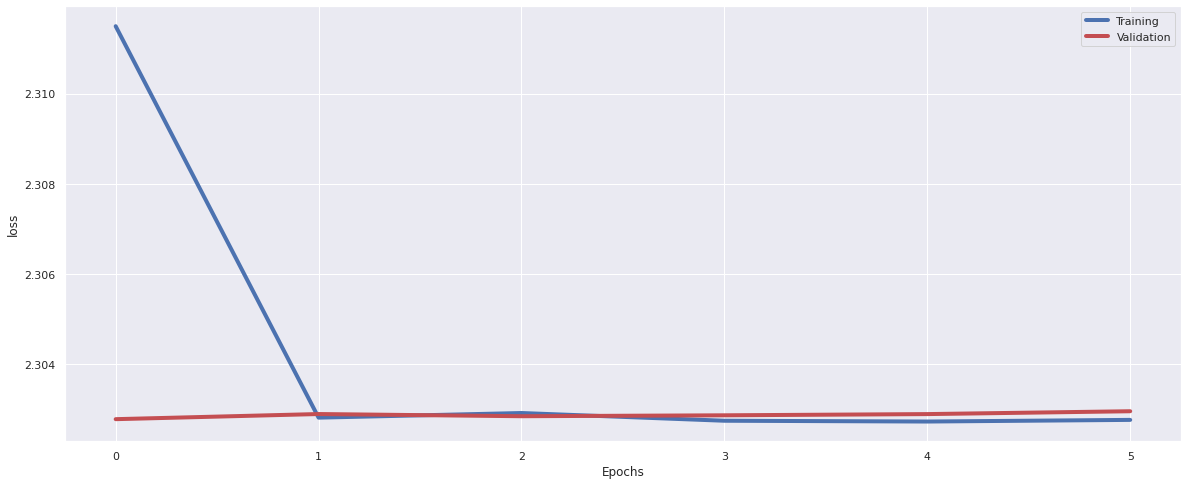

In [ ]:
plot_history(history,plot_type='loss')

In [ ]:
predictions = model.predict(X_test)
print('Weighted F1-score is %.2f' %f1_score(y_test, convert_predictions(predictions), average='weighted'))

313/313 [==============================] - 44s 139ms/step
Weighted F1-score is 0.02


In [ ]:
print('Top-3accuracy %s' % top_k_accuracy_score(y_test, predictions, k=3))

Top-3accuracy 0.2988


Looks like the ResNet50 model needs some tuning for this task, or maybe a lot more iterations to learn.

### Last Performance Check
The last model should be our best model so far. So let's see how the confusion matrix and performance looks like.

313/313 [==============================] - 136s 433ms/step
Weighted F1-score is 0.52


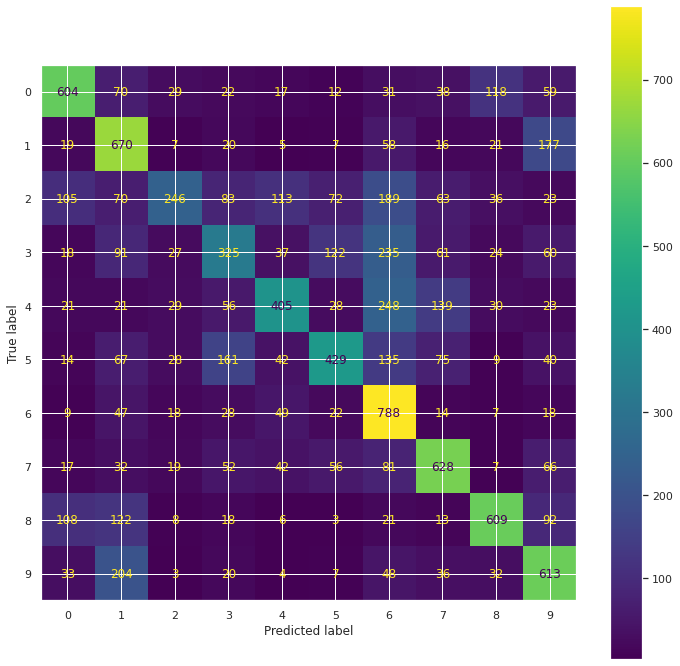

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
predictions = model_vgg.predict(X_test)
print('Weighted F1-score is %.2f' %f1_score(y_test, convert_predictions(predictions), average='weighted'))
fig, ax = plt.subplots(figsize=(12, 12))
ConfusionMatrixDisplay.from_predictions(y_test, convert_predictions(predictions),ax=ax)
plt.show()

In [ ]:
print('Top-3accuracy %s' % top_k_accuracy_score(y_test, predictions, k=3))

Top-3accuracy 0.8313


313/313 [==============================] - 47s 151ms/step
Weighted F1-score is 0.02


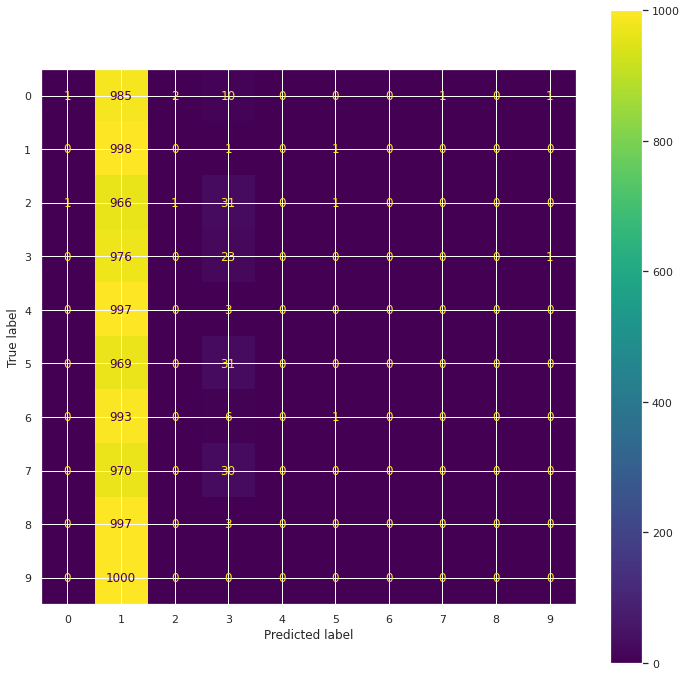

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
predictions = model.predict(X_test)
print('Weighted F1-score is %.2f' %f1_score(y_test, convert_predictions(predictions), average='weighted'))
fig, ax = plt.subplots(figsize=(12, 12))
ConfusionMatrixDisplay.from_predictions(y_test, convert_predictions(predictions),ax=ax)
plt.show()

In [ ]:
print('Top-3accuracy %s' % top_k_accuracy_score(y_test, predictions, k=3))

Top-3accuracy 0.2988
